<a href="https://colab.research.google.com/github/Ashrafalaghbari/oil-production-forecasting/blob/main/optimal_TCN_single_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense,Activation, Dropout
from keras.layers import LSTM, Conv1D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

In [4]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [5]:
# # check if GPU is utilized 
# device_name = tf.config.experimental.list_physical_devices()[-1][-1]
# if device_name != 'GPU':
#     raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(tf.test.gpu_device_name()))

In [6]:
# Select the best features
def select_features(df, target, correlation_type, threshold):
    if (threshold < -1 ) | (threshold > 1 ) :
            raise SystemError('correlation threshold is out of bounds')
    features = df.corr(correlation_type).loc[target].drop(target)
    best_features = features.where(abs(features) > threshold).dropna()
    df = pd.concat([df[target], df[best_features.index]], axis=1)
    return df

# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (columns[j], i)) for j in range(n_vars)]
        # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# scale train and test data to new feature range[0, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(0, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled


# inverse differencing
def inverse_difference(history, interval=1):
	return history[-len(test_scaled)-interval:-interval]


In [7]:
#Evaluation metrics
# compute RMSPE
def RMSPE(x,y):
	result=0
	for i in range(len(x)):
		result += ((x[i]-y[i])/x[i])**2
	result /= len(x)
	result = sqrt(result)
	result *= 100
	return result

# compute MAPE
def MAPE(x,y):
	result=0
	for i in range(len(x)):
		result += abs((x[i]-y[i])/x[i])
	result /= len(x)
	result *= 100
	return result

# compute wMAPE weighted absolute percentage error
def wMAPE(actual, predicted): 
    result_nom = 0
    result_deno = 0
    for i in range(len(actual)):
        result_nom +=  abs(actual[i] - predicted[i])
        result_deno +=  abs(actual[i]) 
    result = result_nom/result_deno
    return result *100

def SMAPE(actual, predicted): #Symmetric (adjusted) MEAN ABSOLUTE PERCENTAGE ERROR (SMAPE)
    result = 0
    for i in range(len(actual)):
        result += abs(actual[i] - predicted[i])/(abs(actual[i]) + abs(predicted[i]))
    result = 2 * result/ len(actual) 
    return result * 100

In [219]:
#load dataset
series = pd.read_csv('/content/drive/MyDrive/volve_production_data/model.csv', 
                     parse_dates=["DATEPRD"], index_col="DATEPRD")
# select feature based on correlation
series = select_features(series, "BORE_OIL_VOL", "spearman", -1)
# select features manually
series =series[["ON_STREAM_HRS",'BORE_GAS_VOL', 'BORE_WAT_VOL',
                'AVG_CHOKE_SIZE_P','F_4_BORE_WI_VOL','F_5_BORE_WI_VOL',
                 "BORE_OIL_VOL"]] 

In [222]:
series

,ON_STREAM_HRS,BORE_GAS_VOL,BORE_WAT_VOL,AVG_CHOKE_SIZE_P,F_4_BORE_WI_VOL,F_5_BORE_WI_VOL,BORE_OIL_VOL
DATEPRD,,,,,,,
2010-01-01,24.0,1.462166e+07,15304.241356,50.150825,44109.287732,49054.221066,18593.749401
2010-01-02,24.0,1.469266e+07,16519.118273,50.694654,41936.969541,51515.296516,18701.242265
2010-01-03,24.0,1.400904e+07,14796.150455,47.665676,41114.572918,51717.286427,17799.912406
2010-01-04,24.0,1.341015e+07,13428.619835,44.706230,40267.292699,51948.640243,17002.616014
2010-01-05,24.0,1.361768e+07,9839.905499,45.743761,40524.238503,52129.744099,17270.939334
...,...,...,...,...,...,...,...
2015-03-19,24.0,1.366424e+06,21779.601368,100.000000,27765.068530,26704.126695,1662.711432
2015-03-20,24.0,1.397308e+06,23586.538158,100.000000,26112.632371,27951.162219,1707.494884
2015-03-21,24.0,1.408435e+06,22172.777429,100.000000,26281.191015,27980.731217,1725.420844


In [9]:
# for i in range(1, steps_ahead+1):
#     series[f"AVG_CHOKE_SIZE_P{i}"] = series['AVG_CHOKE_SIZE_P'].shift(-i)
#     series[f"ON_STREAM_HRS{i}"] = series['ON_STREAM_HRS'].shift(-i)
#     #series[f"BORE_GAS_VOL{i}"] = series['BORE_GAS_VOL'].shift(-i)
# series.drop(["AVG_CHOKE_SIZE_P","ON_STREAM_HRS"], axis=1, inplace=True)
# series.dropna(inplace=True)

In [11]:
# column_to_move = series_supervised.pop("BORE_OIL_VOL(t-1)")
# # insert column with insert(location, column_name, column_value)
# series_supervised.insert(steps_ahead*len(series.columns) -1, "BORE_OIL_VOL(t-1)", column_to_move)

In [12]:
# Create a new directory in My Drive
directory = '/content/drive/My Drive/my_trained_models'
if not os.path.exists(directory):
    os.makedirs(directory)

In [223]:
# # # convert series to stationary 
series_diff = series.copy()
diff_order = 1
series_diff['BORE_OIL_VOL'] = series_diff['BORE_OIL_VOL'].diff(diff_order)
#feature engineering
steps_ahead=2
timesteps=4
# # convert the stationary series to supervise learning
series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= timesteps, n_out= steps_ahead, dropnan=True)   

# drop columns we don't want to predict
pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
# Extract the column names that match the pattern
matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
series_supervised = series_supervised[matching_columns]

In [224]:
series_supervised

,ON_STREAM_HRS(t-4),BORE_GAS_VOL(t-4),BORE_WAT_VOL(t-4),AVG_CHOKE_SIZE_P(t-4),F_4_BORE_WI_VOL(t-4),F_5_BORE_WI_VOL(t-4),BORE_OIL_VOL(t-4),ON_STREAM_HRS(t-3),BORE_GAS_VOL(t-3),BORE_WAT_VOL(t-3),...,BORE_OIL_VOL(t-2),ON_STREAM_HRS(t-1),BORE_GAS_VOL(t-1),BORE_WAT_VOL(t-1),AVG_CHOKE_SIZE_P(t-1),F_4_BORE_WI_VOL(t-1),F_5_BORE_WI_VOL(t-1),BORE_OIL_VOL(t-1),BORE_OIL_VOL(t),BORE_OIL_VOL(t+1)
DATEPRD,,,,,,,,,,,,,,,,,,,,,
2010-01-06,24.0,1.469266e+07,16519.118273,50.694654,41936.969541,51515.296516,107.492863,24.0,1.400904e+07,14796.150455,...,-797.296392,24.00000,1.361768e+07,9839.905499,45.743761,40524.238503,52129.744099,268.323320,60.822469,-193.160084
2010-01-07,24.0,1.400904e+07,14796.150455,47.665676,41114.572918,51717.286427,-901.329859,24.0,1.341015e+07,13428.619835,...,268.323320,24.00000,1.364834e+07,10054.073550,46.053981,40733.215195,52212.108216,60.822469,-193.160084,-10.944270
2010-01-08,24.0,1.341015e+07,13428.619835,44.706230,40267.292699,51948.640243,-797.296392,24.0,1.361768e+07,9839.905499,...,60.822469,24.00000,1.350971e+07,12837.943721,44.740102,39969.857579,51109.971510,-193.160084,-10.944270,-2649.834308
2010-01-09,24.0,1.361768e+07,9839.905499,45.743761,40524.238503,52129.744099,268.323320,24.0,1.364834e+07,10054.073550,...,-193.160084,24.00000,1.349732e+07,10488.510768,44.805229,41079.035678,50933.111950,-10.944270,-2649.834308,2671.659950
2010-01-10,24.0,1.364834e+07,10054.073550,46.053981,40733.215195,52212.108216,60.822469,24.0,1.350971e+07,12837.943721,...,-10.944270,22.83333,1.192758e+07,10120.619746,39.728795,26561.870164,36311.076594,-2649.834308,2671.659950,-76.232504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-03-18,24.0,1.362575e+06,21875.080693,100.000000,27231.502584,26937.428795,9.623410,24.0,1.337302e+06,21926.091057,...,16.605100,24.00000,1.348689e+06,21771.927799,100.000000,26885.294563,27819.994862,18.806534,10.315289,3.270702
2015-03-19,24.0,1.337302e+06,21926.091057,100.000000,27756.502625,26967.735313,-14.026278,24.0,1.344981e+06,22268.759939,...,18.806534,24.00000,1.354500e+06,21725.383201,100.000000,27174.003165,26957.732482,10.315289,3.270702,44.783451
2015-03-20,24.0,1.344981e+06,22268.759939,100.000000,27622.708539,27618.897616,16.605100,24.0,1.348689e+06,21771.927799,...,10.315289,24.00000,1.366424e+06,21779.601368,100.000000,27765.068530,26704.126695,3.270702,44.783451,17.925960


In [225]:


    # # split into train and test sets
    series_supervised = series_supervised.values
    train_size = int(series_supervised.shape[0] * 0.8)
    test_size = series_supervised.shape[0] - train_size
    train, test = series_supervised[0:train_size], series_supervised[train_size:]
    print("train.shape:",train.shape, "test.shape:",test.shape)

    # scale  the data to a feature range(0,1)
    scaler, train_scaled, test_scaled = scale(train, test)
    print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

    # reshape input to be 3D [samples, timesteps, features]
    n_features = len(series.columns)
    train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
    train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
    test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
    test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
    print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
            "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)

train.shape: (1521, 30) test.shape: (381, 30)
train_scaled.shape: (1521, 30) test_scaled.shape: (381, 30)
train_X.shape: (1521, 4, 7) train_y.shape: (1521, 2) test_X.shape: (381, 4, 7) test_y.shape: (381, 2)


In [127]:
def get_hyper_param(n_iteration,n_epochs, layers_seq, neurons_seq, batch_seq, timesteps_seq):
  hyper_param = []
  sequences = set()  
  while len(hyper_param) < n_iteration:
    current_params = []
    current_params.append(np.random.choice(n_epochs)) # number of epochs
    current_params.append(np.random.choice(layers_seq)) # num_hidden_layers
    current_params.append(np.random.choice(neurons_seq)) # 'num_neurons'
    current_params.append(np.random.choice(batch_seq)) # batch_size
    current_params.append(np.random.choice(timesteps_seq)) # previous timesteps
    if tuple(current_params) not in sequences:
      sequences.add(tuple(current_params))
      hyper_param.append(current_params)
  return hyper_param

n_epochs = [700]
layers_seq = [1, 2]
neurons_seq = [4, 8, 16, 32, 64]
batch_seq = [2, 8, 12]
timesteps_seq = [10, 20, 30, 40]
n_iteration = 120

hyper_param = get_hyper_param(n_iteration, n_epochs, layers_seq, neurons_seq, batch_seq, timesteps_seq)
len(hyper_param)

# def check_duplicate_nested_lists(nested_lists):
#     nested_lists = [tuple(lst) for lst in nested_lists]
#     return len(nested_lists) != len(set(nested_lists))

# print(check_duplicate_nested_lists(hyper_param)) # True

False


In [134]:
#hyperparamter tuning
def fit_lstm(steps_ahead = 2):
    
    # For reproducibility 
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(42)
    np.random.seed(12345)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                            inter_op_parallelism_threads=1)
    from keras import backend as K
    tf.random.set_seed(1234)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                                config=session_conf)
    K.set_session(sess)
  
    min_val_loss = 999
    for  n_epochs, num_hidden_layers, num_neurons, batch_size, timesteps in hyper_param:
        print('n_epochs', n_epochs, 'num_hidden_layers', num_hidden_layers, 'num_neurons',
              num_neurons, "batch_size", batch_size, 'timesteps', timesteps)

        #feature engineering
        # # convert the stationary series to supervise learning
        series_supervised = series_to_supervised(series_diff, series_diff.columns, n_in= timesteps, n_out= steps_ahead, dropnan=True)   

        # drop columns we don't want to predict
        pattern = re.compile(r"(t-)|^BORE_OIL_VOL.*")
        # Extract the column names that match the pattern
        matching_columns = [col for col in series_supervised.columns if re.search(pattern, col)]
        series_supervised = series_supervised[matching_columns]

        # # split into train and test sets
        series_supervised = series_supervised.values
        train_size = int(series_supervised.shape[0] * 0.8)
        test_size = series_supervised.shape[0] - train_size
        train, test = series_supervised[0:train_size], series_supervised[train_size:]
        print("train.shape:",train.shape, "test.shape:",test.shape)

        # scale  the data to a feature range(0,1)
        scaler, train_scaled, test_scaled = scale(train, test)
        print('train_scaled.shape:',train_scaled.shape, "test_scaled.shape:",test_scaled.shape)

        # reshape input to be 3D [samples, timesteps, features]
        n_features = len(series.columns)
        train_X, train_y = train_scaled[:, 0:-steps_ahead], train_scaled[:, -steps_ahead:]
        train_X = train_X.reshape(train_X.shape[0], timesteps, n_features)
        test_X, test_y = test_scaled[:, 0:-steps_ahead], test_scaled[:, -steps_ahead:]
        test_X = test_X.reshape(test_X.shape[0], timesteps, n_features )
        print("train_X.shape:",train_X.shape, "train_y.shape:",train_y.shape,
              "test_X.shape:", test_X.shape,"test_y.shape:",test_y.shape)
        
        # build the LSTM model
        model = Sequential()

        if num_hidden_layers != 1:
  
            for num in range(num_hidden_layers-1):
                model.add(LSTM(num_neurons, input_shape=(timesteps, n_features), return_sequences=True))
            model.add(LSTM(num_neurons))

        else:
            model.add(LSTM(num_neurons, input_shape=(timesteps, n_features)))
        model.add(Dense(steps_ahead)) # output layer
        model.compile(loss='mean_squared_error',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
    
        
        #prevent overfitting
        early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
        # save the best weights
        mcp_save = ModelCheckpoint(os.path.join(directory, f'{hyper_param[0]}_weights.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 
        # fit model
        lstm_model = model.fit(train_X, train_y, epochs=n_epochs,
                               callbacks=[early_stopping, mcp_save],
                               batch_size=batch_size,
                            validation_data=(test_X, test_y), verbose=2, shuffle=False)
        
        # Save the model  in HDF5 foramt with a filename that includes the hyperparamters
        model.save(os.path.join(directory, f'{hyper_param[0]}_model.h5'))
        # Load the best weights
        model.load_weights(os.path.join(directory, f'{hyper_param[0]}_weights.hdf5'))
        current_val_loss = model.evaluate(test_X, test_y, verbose=0) #lstm_model.history['val_loss'][-1]
        if current_val_loss < min_val_loss:
            min_val_loss = current_val_loss
            best_params = [n_epochs,  num_hidden_layers, num_neurons, batch_size, timesteps]

        
    print('final best params',"n_epochs:",n_epochs,"num_hidden_layers:",
          num_hidden_layers,"batch_size:",batch_size,"timesteps:",timesteps) 
    return {"best_params": str(best_params) , "MSE": np.round(min_val_loss, 5)}#, lstm_model

In [50]:
# # run the model and repeat the evaluation to reduce the certainty asscoicated with the random initialization of model weights
# def run_model(n_repeats = 1):
#     scores = [fit_lstm_random() for _ in range(n_repeats)]
#     result = pd.DataFrame(scores)
#     result = result.groupby("best_params").mean()
#     return result

In [138]:
hyper_param = [[700, 1,12,8, 10  ], [700, 1,12,8, 20  ], [700, 1,12,8, 30  ]]

In [139]:
_, model = fit_lstm()

n_epochs 700 num_hidden_layers 1 num_neurons 12 batch_size 8 timesteps 10
train.shape: (1516, 72) test.shape: (380, 72)
train_scaled.shape: (1516, 72) test_scaled.shape: (380, 72)
train_X.shape: (1516, 10, 7) train_y.shape: (1516, 2) test_X.shape: (380, 10, 7) test_y.shape: (380, 2)
Epoch 1/700
190/190 - 52s - loss: 0.4556 - val_loss: 0.2290 - 52s/epoch - 275ms/step
Epoch 2/700
190/190 - 1s - loss: 0.1404 - val_loss: 0.0422 - 854ms/epoch - 4ms/step
Epoch 3/700
190/190 - 1s - loss: 0.0333 - val_loss: 0.0072 - 783ms/epoch - 4ms/step
Epoch 4/700
190/190 - 1s - loss: 0.0174 - val_loss: 0.0063 - 801ms/epoch - 4ms/step
Epoch 5/700
190/190 - 1s - loss: 0.0158 - val_loss: 0.0061 - 769ms/epoch - 4ms/step
Epoch 6/700
190/190 - 1s - loss: 0.0146 - val_loss: 0.0057 - 795ms/epoch - 4ms/step
Epoch 7/700
190/190 - 1s - loss: 0.0134 - val_loss: 0.0052 - 637ms/epoch - 3ms/step
Epoch 8/700
190/190 - 1s - loss: 0.0124 - val_loss: 0.0048 - 766ms/epoch - 4ms/step
Epoch 9/700
190/190 - 1s - loss: 0.0114 - v

KeyboardInterrupt: ignored

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons=30# 22

model = Sequential()
model.add(LSTM(neurons, activation="tanh",
               input_shape=(timesteps, n_features)))

model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-3, mode='min')

# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()


# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=8, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

In [243]:
from keras.layers import GRU 
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons=30# 22

model = Sequential()
model.add(LSTM(neurons, activation="tanh",
               input_shape=(timesteps, n_features)))

model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 
#reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-3, mode='min')

# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()


# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_scaled[:,:-2], train_scaled[:,-2:], callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=8, validation_data=(test_scaled[:,:-2], test_scaled[:,-2:]),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))


Epoch 1/700


ValueError: ignored

In [237]:
train_X.shape

(1521, 4, 7)

In [239]:
test_X.shape

(381, 4, 7)

In [236]:
train_y.shape

(1521, 2)

In [238]:
test_y.shape

(381, 2)

In [ ]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  
os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
np.random.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)
from keras import backend as K
tf.random.set_seed(1234)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), 
                            config=session_conf)
K.set_session(sess)

# fit the model
neurons= 30

model = Sequential()
model.add(Conv1D(filters = 46, kernel_size=1, dilation_rate=1, padding='same',
                 input_shape=(timesteps, n_features)))
model.add(Conv1D(filters = 25, kernel_size=1, dilation_rate=1, padding='same'))
model.add(Conv1D(filters = 10, kernel_size=1, dilation_rate=1, padding='same'))
#model.add(Conv1D(filters = 46, kernel_size=10, dilation_rate=1, padding='causal'))
model.add(Conv1D(filters = 46, kernel_size=2, dilation_rate=1, padding='causal'))


model.add(Dense(steps_ahead)) # output layer
model.compile(loss='mean_squared_error',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
                                restore_best_weights=True, mode='min')
# save the best weights if training is interrupted
mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
                            save_best_only=True,
                            monitor='val_loss', mode='min') 


# Set the initial and total number of epochs
initial_epoch = 1
n_epochs = 700
loss_tracking = list()

# Run the training loop
for epoch in range(initial_epoch , n_epochs+1):
    print(f'Epoch {epoch}/{n_epochs}')
    # Train the model for one epoch
    history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save],
                    epochs=1, batch_size=2, validation_data=(test_X, test_y),
                     verbose=2,
                     shuffle=False)
    # to find for which epoch each loss belongs
    validation_loss= model.evaluate(test_X, test_y, verbose=0)
    loss_tracking.append(validation_loss)
    # Save the model every 10 epochs
    if epoch % 100 == 0:
        # Save the model  in HDF5 foramt with a filename that includes the epoch number
        #model.save(f'model_{epoch}Eps.h5')
        model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

In [ ]:
#  best tcn architecture is the one used in the papaer

In [55]:
# load the trained saved model
model_saved = tf.keras.models.load_model('/content/drive/MyDrive/my_trained_models/[50, 1, 8, 2, 20]_model.h5')

In [56]:
# Load the best weights
model_saved.load_weights('/content/drive/MyDrive/my_trained_models/[50, 1, 8, 2, 20]_weights.hdf5')

In [148]:
# Load the best weights
model.load_weights(os.path.join(directory, 'mdl_wts.hdf5'))

In [150]:
model.evaluate(test_X, test_y, verbose=0)

0.0003296691575087607

In [ ]:
score = model.evaluate(test_X, test_y, verbose=0)
best_epoch = loss_tracking.index(score) + 1
# validation loss and corresponding epoch for the saved model
print(f'Epoch:{best_epoch}\nValidation loss: {score}') 

Epoch:82
Validation loss: 6.0132886574137956e-05


In [ ]:
# # continue if training is interrupted 
# model.compile(loss='mean_squared_error',
#               optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5))
# early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=2,
#                                 restore_best_weights=True, mode='min')
# # save the best weights if training is interrupted
# mcp_save = ModelCheckpoint(os.path.join(directory, 'mdl_wts.hdf5'),
#                             save_best_only=True,
#                             monitor='val_loss', mode='min') 
# reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-4, mode='min')

# # Set the initial and total number of epochs
# initial_epoch = 1
# n_epochs = 2000

# # Run the training loop
# for epoch in range(initial_epoch , n_epochs+1):
#     print(f'Epoch {epoch}/{n_epochs}')
#     # Train the model for one epoch
#     history = model.fit(train_X, train_y, callbacks=[early_stopping, mcp_save, reduce_lr_loss],
#                     epochs=1, batch_size=2, validation_data=(test_X, test_y),
#                      verbose=2,
#                      shuffle=False)
#     # to find for which epoch each loss belongs
#     validation_loss= model.evaluate(test_X, test_y, verbose=0)
#     loss_tracking.append(validation_loss)
#     # Save the model every 10 epochs
#     if epoch % 50 == 0:
#         # Save the model  in HDF5 foramt with a filename that includes the epoch number
#         #model.save(f'model_{epoch}Eps.h5')
#         model.save(os.path.join(directory, f'model_{epoch}Eps.h5'))

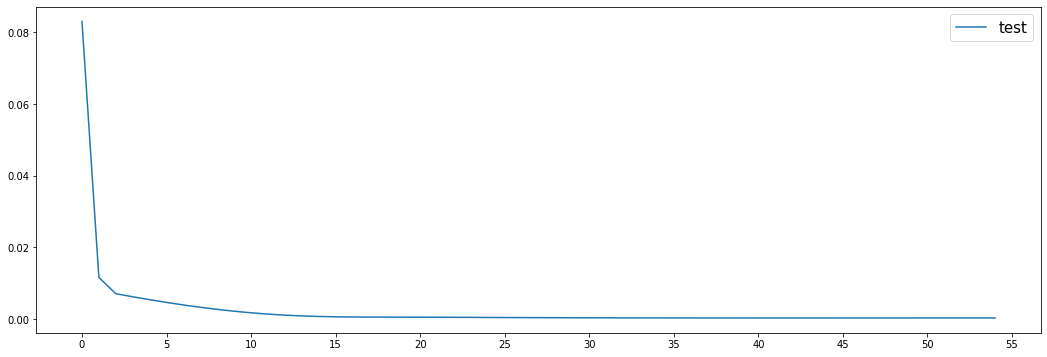

In [151]:
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
ax.xaxis.set_major_locator(plt.MultipleLocator(5))
#plt.plot(history.history['loss'], label='train')
plt.plot(loss_tracking, label='test')
plt.legend(fontsize=15)
plt.show()

**MinMax Scaler equation**
$$x' = \frac{(x - min)}{(max - min)} \times (new\ max\ value - new\ min\  value) + new\ min\ value$$<br/>


$$x = \frac{(max - min)\times (new\ min\ value + x') + (new\ max\ value - new\ min\ value)\times min}{new\ max\ value - new\ min\ value}$$

Where:

$x$ is the inverse scaled value
$x'$ is the scaled value
$min$ is the minimum value of the original data
$max$ is the maximum value of the original data.<br/>
$new\ max\ value$ and $new\ min\ value$ is the new range that we want to scale the data to. For example: $(1,0)\ or\ (1,-1)$

In [153]:
# make a prediction 
# select the number of obersvtions for prediction
n_obs = len(test)
yhat = model.predict(test_X[-n_obs:], verbose=1)


# invert scaling 
scaled_y = pd.DataFrame(test_y)
scaled_yhat = pd.DataFrame(yhat) ## ravel () converting into 1D array
#obtain the min and max from the training set
unscaled_train = pd.DataFrame(series_supervised[:len(train)])
#new feature range
new_max_value = 1 
new_min_value= 0
feature_range = new_max_value - new_min_value

def transform_column(column):
    min_value = min(unscaled_train.iloc[:, -steps_ahead + column.name])
    max_value = max(unscaled_train.iloc[:, -steps_ahead + column.name])
    return ((max_value - min_value) * (new_min_value + column) + (feature_range  * min_value)) / feature_range 
    
# invert scaling for actual
inv_scale_y = scaled_y.apply(transform_column, axis=0)
inv_scale_y = inv_scale_y.values
# invert scaling for forecast
inv_scale_yhat = scaled_yhat.apply(transform_column, axis=0)
inv_scale_yhat = inv_scale_yhat.values

12/12 [==============================] - 1s 2ms/step


In [154]:
pd.DataFrame(inv_scale_y)

,0,1
0,-112.776304,-27.234880
1,-27.234880,23.335197
2,23.335197,-377.514432
3,-377.514432,-30.505581
4,-30.505581,-21.322458
...,...,...
376,10.315289,3.270702
377,3.270702,44.783451
378,44.783451,17.925960
379,17.925960,-104.788245


In [155]:
# Invert the Differencing for actual 
df = pd.DataFrame(series.iloc[-len(test)-steps_ahead:,-1])
n_vars = df.shape[1]
columns = df.columns
cols, names = list(), list()
for i in range(0, steps_ahead):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('%s(t)' % (columns[j])) for j in range(n_vars)]
    else:
        names += [('%s(t+%d)' % (columns[j], i)) for j in range(n_vars)]
# put it all together
agg = pd.concat(cols, axis=1)
agg.columns = names
agg.dropna(inplace=True)
agg = agg.iloc[:-1]
#drop all the variables that we don't want to predict
#agg.drop(columns=vars_to_drop, inplace=True)
agg = agg.to_numpy()
inv_y = np.add(inv_scale_y,agg)

* To invert the differencing of time series for multistep prediction:<br/>
The equation is given by $$
\hat x_{t+h|t}=x_t+(\widehat{\Delta x_{t+1}}+\dots+\widehat{\Delta x_{t+h}}).
$$ <br/>
where: <br/>
$\hat x_{t+h|t}$ is the predicted value of the time series x at time $t$+h, given the value of the time series at time $t$.<br/>
$x_t$ is the value of the time series $x$ at time t.<br/>
${\Delta x_{t+1}}$ is the difference between the value of the time series $x$ at time $t+1$ and the value of the time series at time t.<br/>
${\Delta x_{t+2}}$ is the difference between the value of the time series $x$ at time $t+2$ and the value of the time series at time $t+1$.<br/>
${\Delta x_{t+h}}$ is the difference between the value of the time series $x$ at time $t+h$ and the value of the time series at time $t+h-1$.

In [205]:
# Invert the Differencing for forecast
# to invert the diffrenced predicted values,the the predicted differenced value is added
# to previous predicted diffenced values and last available observation in test set(Xt) as explained above
originalSeries_supervised = series_to_supervised(series, series.columns, n_in=timesteps, n_out=steps_ahead, dropnan=True)
current_timestep = 1
originalSeries_xt = originalSeries_supervised[['BORE_OIL_VOL(t)','BORE_OIL_VOL(t+1)']]
# A predicted value at any given step ahead is a result of the previous cumulative differnced predicted values and current time step
col = []
inv_yhat_cum = np.cumsum(inv_scale_yhat, axis=1)

for i in range(n_obs):
    #.ravel() flattens the series into a one-dimensional array
    inverted_diff_yhat = originalSeries_xt[-n_obs:].values[i] + inv_yhat_cum[i]
    col.append(inverted_diff_yhat)
col = pd.DataFrame(col)
inv_yhat = col.values # convert df to NumpyArray

In [216]:
# Performance evaluation
rmse_test, RMSPE_test, MAE_test, MAPE_test, r2_test, wMAPE_test, SMAPE_test  = [], [], [], [], [], [], []
# calculate the score for each day

for i in range(test_y.shape[1]):
    result_rmse = sqrt(mean_squared_error(inv_y[:,i], inv_yhat[:,i]))
    result_RMSPE = RMSPE(inv_y[:,i], inv_yhat[:,i])
    result_MAE = mean_absolute_error(inv_y[:,i], inv_yhat[:,i])
    result_MAPE = MAPE(inv_y[:,i], inv_yhat[:,i])
    result_r2 = r2_score(inv_y[:,i], inv_yhat[:,i])
    result_wMAPE = wMAPE(inv_y[:,i], inv_yhat[:,i])
    result_SMAPE = SMAPE(inv_y[:,i], inv_yhat[:,i])

    rmse_test.append(result_rmse)
    RMSPE_test.append(result_RMSPE)
    MAE_test.append(result_MAE)
    MAPE_test.append(result_MAPE)
    r2_test.append(result_r2)
    wMAPE_test.append(result_wMAPE)
    SMAPE_test.append(result_SMAPE)
    
## calculate overall score
print("The Average scores for the vector output {} steps ahead:\n".format(steps_ahead))
print('Test RMSE: %.5f' % np.mean(rmse_test))
#print('Test RMSPE: %.5f' % np.mean(RMSPE_test)) because of that the denominator (actual) has some zero values
print('Test MAE: %.5f' % np.mean(MAE_test))
#print('Test MAPE: %.5f' % np.mean(MAPE_test)) #because of that the denominator (actual) has some zero values
print('Test r2: %.5f' % np.mean(r2_test))
print('Test wMAPE: %.5f ' % np.mean(wMAPE_test))
print('Test SMAPE: %.5f ' % np.mean(SMAPE_test))

The Average scores for the vector output 2 steps ahead:

Test RMSE: 517.58664
Test MAE: 304.76658
Test r2: 0.45559
Test wMAPE: 13.34431 
Test SMAPE: 16.53452 


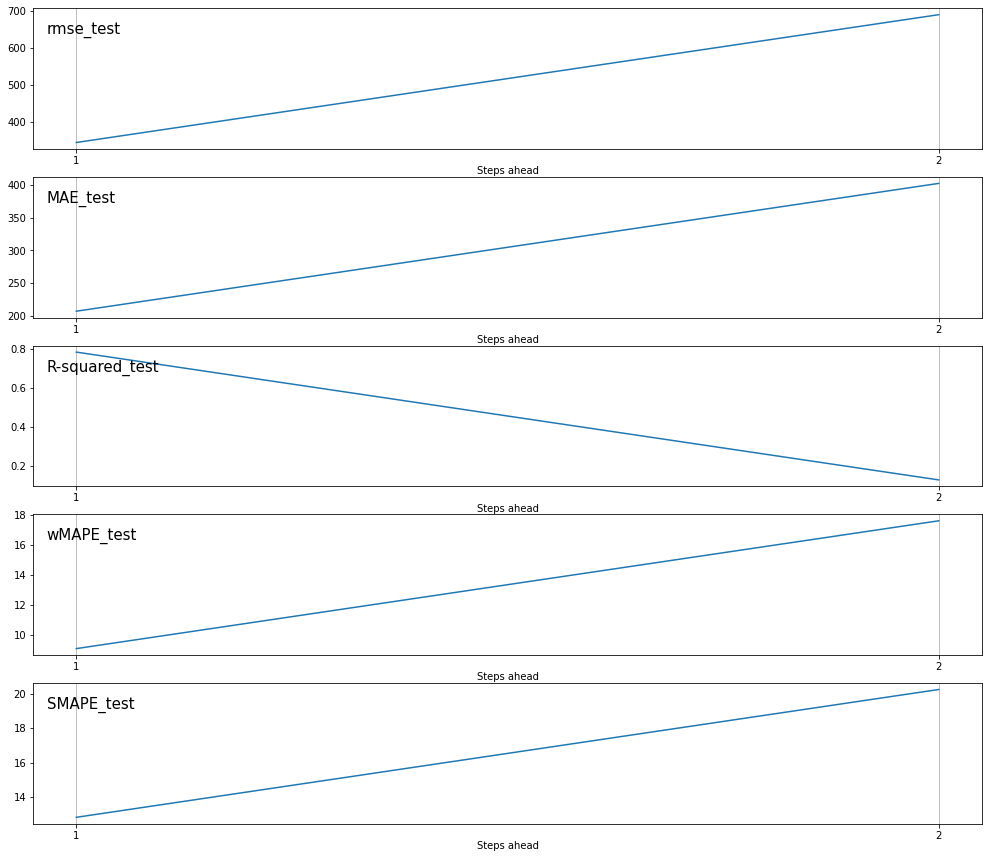

In [210]:
# plot the scores for each time step of the multi-step forecast
scores = pd.DataFrame({"rmse_test":rmse_test, "MAE_test":MAE_test, "R-squared_test":r2_test, "wMAPE_test":wMAPE_test, "SMAPE_test":SMAPE_test})

# Reset the index, keeping the old index as a column
scores = scores.reset_index(drop=False)

# Set the 'index' column as the new index
scores.index = scores['index'] + 1

# Drop the old 'index' column
scores = scores.drop(columns='index')

data = scores.columns

# Creating figure with two rows and one column
fig, axs = plt.subplots(nrows=len(data), figsize=(17, 15))

axs = axs.ravel()

for id, column in enumerate(data):
    # Set the x-axis limits
    #axs[id].set_xlim(xmin=1, xmax= steps_ahead)
    #print the name of the test on plot
    axs[id].plot(scores[column])
    # Add a title to the x-axis
    axs[id].set_xlabel('Steps ahead',fontsize=10, labelpad=0.1)
    axs[id].grid(True)
    # Remove the horizontal grid lines
    axs[id].grid(which='both', axis='y')
    axs[id].xaxis.set_major_locator(plt.MultipleLocator(1))
    axs[id].legend([column], loc='upper left', fontsize=15, handlelength=0, handletextpad=0, frameon=False)
    
plt.show()

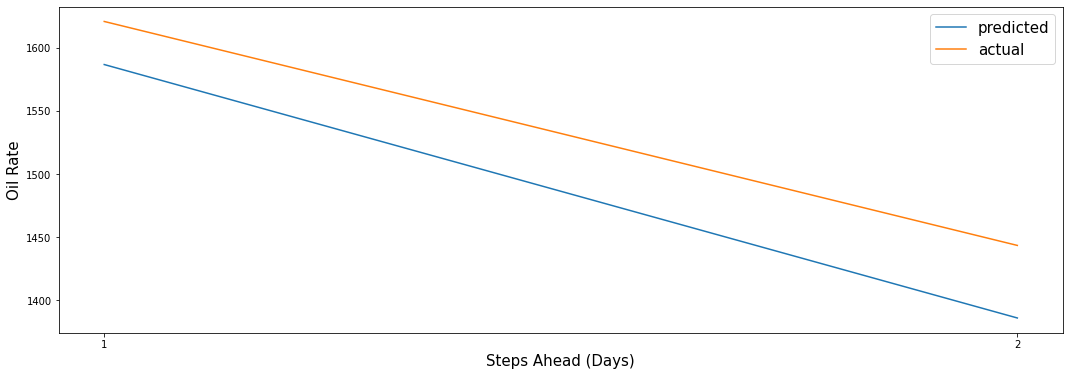

In [212]:
# plot the last forecasted values on test set
fig, ax = plt.subplots(1, 1, figsize=(18,6)) 
# Set the major locator for the x-axis
x = list(range(1, len(inv_yhat[-1])+1))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.plot(x, inv_yhat[-1], label = "predicted")
ax.plot(x, inv_y[-1], label = "actual")
ax.set_ylabel('Oil Rate', fontsize=15)
ax.set_xlabel('Steps Ahead (Days)',fontsize=15)
plt.legend(fontsize=15)
plt.show()